# Generate features (acoustic, phonetic, and lexical) for stimuli
## 0. Some basic functions
### 0.1. Test multicollinearity

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_multicollinearity(X_i,corr_labels):
    
    # Ensure the input is a NumPy array
    if not isinstance(X_i, np.ndarray):
        raise ValueError("Input X_i must be a NumPy array")

    # Compute VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = corr_labels
    vif_data["VIF"] = [variance_inflation_factor(X_i, i) for i in range(X_i.shape[1])]

    # Plot correlation matrix as a heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = np.corrcoef(X_i, rowvar=False)  # Compute correlation matrix
    sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap="coolwarm", xticklabels=corr_labels, yticklabels=corr_labels,annot_kws={"size": 10})
    plt.title("Feature Correlation Matrix")
    plt.show()

    return vif_data

### 0.2. PCA


In [3]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA

def perform_pca_on_acoustic_features(envelope_feature_dict, original_feature_names,n_components=None, visualize=True, min_variance_retention=0.95):
    """
    Performs Principal Component Analysis (PCA) on a dictionary of acoustic features.

    Args:
        envelope_feature_dict (dict): A dictionary where keys are sample/word identifiers
                                      (e.g., 'bacon', 'bagel') and values are lists
                                      of their corresponding acoustic features (e.g., power envelope means
                                      across different frequency bands).
        n_components (int or float or None, optional): The number of components to keep after PCA.
            - If int: The exact number of principal components to return.
            - If float (0.0 < n_components < 1.0): The proportion of variance to explain.
              PCA will select the minimum number of components such that the explained variance
              is greater than or equal to this value.
            - If None (default): All components will be kept. The function will then
              suggest an optimal number based on `min_variance_retention`.
        visualize (bool, optional): If True, generate plots for explained variance and
                                     (if applicable) a scatter plot of the first two principal components.
                                     Defaults to True.
        min_variance_retention (float, optional): Only used if `n_components` is None.
            Specifies the minimum cumulative explained variance ratio (between 0 and 1)
            to retain for suggesting the number of components. Defaults to 0.95.

    Returns:
        tuple: A tuple containing:
            - pca_transformed_df (pd.DataFrame): DataFrame with the transformed principal components.
                                                Rows are samples, columns are principal components (PC1, PC2, ...).
            - pca_model (sklearn.decomposition.PCA): The fitted PCA model object.
            - scaler_model (sklearn.preprocessing.StandardScaler): The fitted StandardScaler model object.
    """

    print("--- Starting PCA Analysis ---")

    # 1. Convert the dictionary to a Pandas DataFrame
    # Each row will represent a sample (word), and each column will represent a feature (frequency band).
    df = pd.DataFrame.from_dict(envelope_feature_dict, orient='index')

    print(f"\nOriginal data shape: {df.shape} (samples x features)")
    # print("Original data (first 5 rows):\n", df.head()) # Uncomment for full data view

    # 2. Data Standardization
    # PCA is sensitive to feature scales, so standardization is a crucial step.
    # StandardScaler transforms data to have a mean of 0 and a standard deviation of 1.
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)
    # print("\nScaled data (first 5 rows):\n", scaled_df.head()) # Uncomment for full data view

    # 3. Perform PCA (initial fit to get explained variance, if n_components is not directly specified)
    # If n_components is already specified, we'll directly use it.
    if n_components is None:
        pca = PCA() # Fit without specifying components to analyze explained variance
        pca.fit(scaled_data)
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_explained_variance = np.cumsum(explained_variance_ratio)

        print("\nExplained variance per principal component:\n", explained_variance_ratio)
        print("\nCumulative explained variance:\n", cumulative_explained_variance)

        # Suggest optimal number of components based on min_variance_retention
        if len(cumulative_explained_variance) > 0:
            suggested_n_components = np.where(cumulative_explained_variance >= min_variance_retention)[0][0] + 1
            print(f"\nTo retain at least {min_variance_retention*100:.0f}% of the variance, "
                  f"it's suggested to select {suggested_n_components} principal components.")
            final_n_components = suggested_n_components
        else:
            final_n_components = 0
            print("No principal components could be determined from the data.")
    else:
        # If n_components is provided, use it directly
        final_n_components = n_components
        print(f"\nProceeding with PCA using n_components = {final_n_components}")

    # 4. Re-execute PCA with the determined or specified number of components
    if final_n_components > 0:
        pca_model = PCA(n_components=final_n_components)
        principal_components = pca_model.fit_transform(scaled_data)

        # Convert principal components to a DataFrame for easier handling
        pc_column_names = [f'PC{i+1}' for i in range(principal_components.shape[1])]
        pca_transformed_df = pd.DataFrame(data=principal_components, index=df.index, columns=pc_column_names)
        print(f"\nFinal PCA transformed data shape: {pca_transformed_df.shape}")
        print("PCA transformed data (first 5 rows):\n", pca_transformed_df.head())
    else:
        pca_transformed_df = pd.DataFrame(index=df.index) # Empty DataFrame if no components
        pca_model = None
        print("PCA could not be performed with the specified parameters or data.")
        
    # 5. Normolize results
    min_max_scaler = MinMaxScaler()
    # Apply Min-Max Scaling to the PCA transformed DataFrame
    normalized_pca_data = min_max_scaler.fit_transform(pca_transformed_df)
    normalized_pca_df = pd.DataFrame(normalized_pca_data,
                                     index=pca_transformed_df.index,
                                     columns=pca_transformed_df.columns)


    # 5. Visualization (Optional)
    if visualize and pca_model is not None:
        # Plot Explained Variance Ratio (if full PCA was done initially)
        if n_components is None and len(cumulative_explained_variance) > 0:
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
            plt.axhline(y=min_variance_retention, color='r', linestyle=':', label=f'{min_variance_retention*100:.0f}% Variance')
            plt.axvline(x=final_n_components, color='g', linestyle=':', label=f'{final_n_components} Components')
            plt.title('PCA - Cumulative Explained Variance')
            plt.xlabel('Number of Principal Components')
            plt.ylabel('Cumulative Explained Variance Ratio')
            plt.xticks(range(1, len(explained_variance_ratio) + 1))
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # Scatter plot of the first two principal components (if at least 2 components are kept)
        # if final_n_components >= 2:
        #     plt.figure(figsize=(8, 6))
        #     sns.scatterplot(x=pca_transformed_df.iloc[:, 0], y=pca_transformed_df.iloc[:, 1],
        #                     hue=pca_transformed_df.index, s=100, palette='viridis')
        #     plt.title('PCA - Scatter Plot of First Two Principal Components')
        #     plt.xlabel(f'Principal Component 1 (explains {pca_model.explained_variance_ratio_[0]*100:.2f}%)')
        #     plt.ylabel(f'Principal Component 2 (explains {pca_model.explained_variance_ratio_[1]*100:.2f}%)')
        #     plt.grid(True)
        #     # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        #     plt.tight_layout()
        #     plt.show()
        # elif final_n_components == 1:
        #     print("\nOnly one principal component was retained. A 2D scatter plot is not applicable.")
        # --- New: Plotting Feature Loadings (Contributions) ---
        
        print("\n--- Visualizing Feature Loadings ---")
        # pca_model.components_ gives the principal axes in feature space (loadings)
        # It has shape (n_components, n_features)
        loadings_df = pd.DataFrame(pca_model.components_,
                                   columns=original_feature_names,
                                   index=pc_column_names)

        plt.figure(figsize=(12, 8))
        sns.heatmap(loadings_df, cmap='viridis', annot=True, fmt=".2f", linewidths=.5, linecolor='black')
        plt.title('Principal Component Loadings (Contribution of Original Features to PCs)')
        plt.xlabel('Original Features')
        plt.ylabel('Principal Components')
        plt.tight_layout()
        plt.show()

        # Optional: Bar plot for individual PC loadings (e.g., PC1)
        if final_n_components >= 1:
            plt.figure(figsize=(12, 6))
            loadings_df.loc['PC1'].plot(kind='bar')
            plt.title('Loadings of Original Features on Principal Component 1 (PC1)')
            plt.xlabel('Original Features')
            plt.ylabel('Loading Value')
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', linestyle='--')
            plt.tight_layout()
            plt.show()
            
        print("\n--- Visualizing Clustered Feature Correlations ---")
        # Calculate the correlation matrix of the original (scaled) features
        plt.figure(figsize=(10, 8))
        # Use sns.clustermap which performs hierarchical clustering by default
        # The 'cbar_kws' argument helps to control the color bar label
        sns.clustermap(loadings_df, cmap='coolwarm', annot=True, fmt=".2f",
                       linewidths=.5, figsize=(12, 10),
                       cbar_kws={'label': 'Correlation Coefficient'})
        plt.suptitle('Clustered Heatmap of Original Feature Correlations', y=1.02) # Adjusted title position
        plt.show()
            
    print("\n--- PCA Analysis Complete ---")
    return normalized_pca_df, pca_model, scaler

## 1. Phonemic feature matrix
### 1.1. Get MFA dictionary

In [4]:
def read_syllable_dict(file_path):
    """
    Reads a file and returns a dictionary with words as keys and phoneme lists as values.
    Ignores the numeric middle section between tabs, extracting only word and phonemes.
    
    Args:
        file_path (str): Path to the file
    
    Returns:
        dict: {word: [phonemes]}
    """
    syllable_dict = {}
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Remove leading/trailing whitespace and split by tabs
            parts = line.strip().split('\t')

            # Extract word (first part) and phonemes (third part)
            word = parts[0].replace("'", "")  # Remove single quotes if present
            if len(parts) == 6:
                phonemes_str = parts[5]  # Third part is the phonemes
            elif len(parts) == 2:
                phonemes_str = parts[1]  # Third part is the phonemes
            else:
                continue

            # Split phonemes by spaces into a list
            phonemes = phonemes_str.split()
            if not phonemes:  # If no phonemes found, skip the line
                print(f"No phonemes found in line: {line.strip()}")
                continue
                
            # Store in dictionary
            syllable_dict[word] = phonemes
    
    return syllable_dict

In [26]:
file_path = "english_us_lr.dict"
# Create the filename-to-phoneme dictionary
dict = read_syllable_dict(file_path)
for word, syllables in list(dict.items())[:10]:
    print(f"{word}: {syllables}")

d: ['D']
ll: ['L']
re: ['R', 'EY1']
s: ['EH1', 'S']
ve: ['V', 'IY1', 'IY1']
[bracketed]: ['spn']
<cutoff>: ['spn']
a: ['EY1']
as: ['EH1', 'Z']
abody: ['EY1', 'B', 'AA2', 'D', 'IY0']


### 1.2. Get the stimuli phonemic dictionary for the Lexical Delay Experiment

In [27]:
import os

def get_wav_files(directory):
    wav_files_names = {}
    wav_files = []
    # Check if directory exists
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist.")
        return wav_files
    
    # Iterate through files in the directory
    for filename in os.listdir(directory):
        if filename.lower().endswith('.wav'):  # Case-insensitive check for .wav files
            # Add to dictionary (key is filename, value can be None or customized)
            wav_files_names[filename[:-4]] = None
    return wav_files_names

In [28]:
def create_phoneme_start_time_dict(syllables, base_path:str='C:\\Users\\bl314\\Box\\CoganLab\\ECoG_Task_Data\\Stim\\Lexical\\mfa\\stim_annotations'):
    phoneme_start_times = {}
    for word in syllables.keys():
        print(f'getting timestamps of word {word}')
        file_path = os.path.join(base_path, f"{word}_phones.txt")
        try:
            with open(file_path, 'r') as f:
                start_times = []
                for i, line in enumerate(f):
                    if i < 5: 
                        parts = line.strip().split('\t')
                        if parts:
                            start_times.append(float(parts[0]))
                    else:
                        break
                phoneme_start_times[word] = start_times
        except FileNotFoundError:
            print(f"Not found {file_path}. Skipped {word}")
    return phoneme_start_times

In [29]:
directory = r"C:\Users\bl314\Box\CoganLab\task_stimuli\LexicalDecRepDelay"
syllables = get_wav_files(directory)
for syllable in syllables.keys():
    syllables[syllable] = dict.get(syllable)
    if syllable=='pilot' and len(syllables[syllable])<5:
        syllables[syllable].append('T')
    print(f"{syllable}: {syllables[syllable]}")
syllables_timestamps = create_phoneme_start_time_dict(syllables)
print(syllables_timestamps)

bacon: ['B', 'EY1', 'K', 'AH0', 'N']
bagel: ['B', 'EY1', 'G', 'AH0', 'L']
banel: ['B', 'AE1', 'N', 'AH0', 'L']
banic: ['B', 'AE1', 'N', 'IH0', 'K']
baron: ['B', 'AE1', 'R', 'AH0', 'N']
basin: ['B', 'EY1', 'S', 'AH0', 'N']
belet: ['B', 'EH1', 'L', 'EH0', 'T']
berin: ['B', 'AE1', 'R', 'IH0', 'N']
beris: ['B', 'AE1', 'R', 'IH0', 'S']
bison: ['B', 'AY1', 'S', 'AH0', 'N']
bonus: ['B', 'OW1', 'N', 'AH0', 'S']
boreb: ['B', 'AO1', 'R', 'AH0', 'B']
boril: ['B', 'AO1', 'R', 'AH0', 'L']
cabin: ['K', 'AE1', 'B', 'AH0', 'N']
camel: ['K', 'AE1', 'M', 'AH0', 'L']
caris: ['K', 'AE1', 'R', 'AH0', 'S']
casef: ['K', 'AA1', 'S', 'IH0', 'F']
cazel: ['K', 'AA1', 'Z', 'AH0', 'L']
civic: ['S', 'IH1', 'V', 'IH0', 'K']
civil: ['S', 'IH1', 'V', 'AH0', 'L']
cobin: ['K', 'AA1', 'B', 'IH0', 'N']
colon: ['K', 'OW1', 'L', 'AH0', 'N']
comet: ['K', 'AA1', 'M', 'AH0', 'T']
comic: ['K', 'AA1', 'M', 'IH0', 'K']
coral: ['K', 'AO1', 'R', 'AH0', 'L']
davel: ['D', 'EY1', 'V', 'AH0', 'L']
delin: ['D', 'EH1', 'L', 'IH0', 'N']
d

In [31]:
#For LME: save phoneme categories and timestamps for each syllable
import pickle
lme_dir = 'D:\\bsliang_Coganlabcode\\coganlab_ieeg\\projects\\lme\\data'
filename = os.path.join(lme_dir,'stim_pho_dict.pkl')
with open(filename, 'wb') as f:
    pickle.dump(syllables, f)
filename = os.path.join(lme_dir,'stim_pho_t_dict.pkl')
with open(filename, 'wb') as f:
    pickle.dump(syllables_timestamps, f)

### 1.3. One-hot encoding for each unique phoneme

In [29]:
# Get unique phoneme vector
all_phonemes = set()
for phonemes in syllables.values():
    all_phonemes.update(phonemes)
all_phonemes = sorted(list(all_phonemes))  # Sort for consistent ordering
phoneme_to_index = {phoneme: idx for idx, phoneme in enumerate(all_phonemes)}
vector_length = len(all_phonemes)

# Create one-hot encoding for each word
phoneme_one_hot_dict = {}
for word, phonemes in syllables.items():
    # Initialize vector with zeros
    vector = [0] * vector_length
    # Set 1 for each phoneme present in the word
    for phoneme in phonemes:
        vector[phoneme_to_index[phoneme]] = 1
    phoneme_one_hot_dict[word] = vector

C:\Users\bl314\AppData\Local\anaconda3\envs\ieeg\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


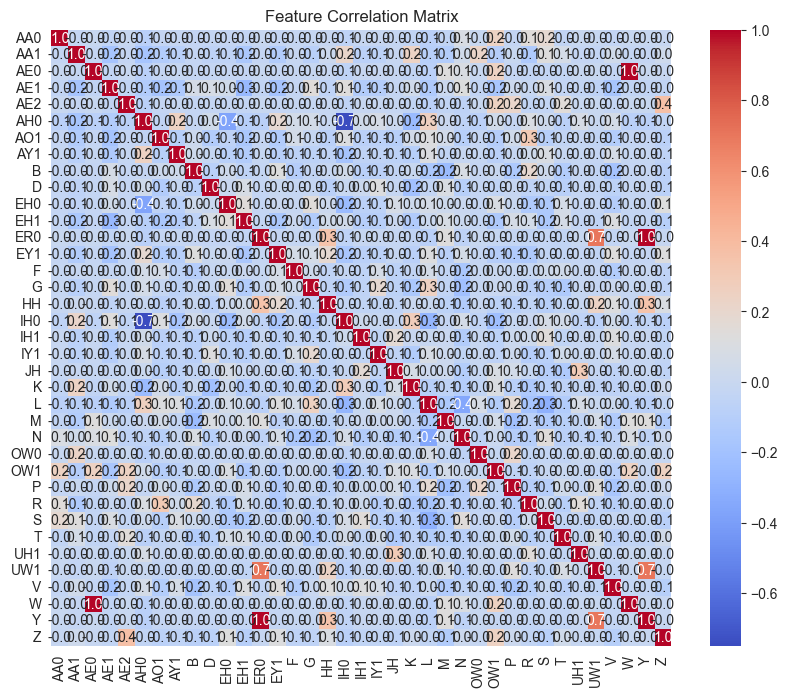

fatal: ['F', 'EY1', 'T', 'AH0', 'L'] contains T, L and AH0
fetal: ['F', 'IY1', 'T', 'AH0', 'L'] contains T, L and AH0
humor: ['HH', 'Y', 'UW1', 'M', 'ER0'] contains ER0
humor: ['HH', 'Y', 'UW1', 'M', 'ER0'] contains Y
humor: ['HH', 'Y', 'UW1', 'M', 'ER0'] contains UW1
humor: ['HH', 'Y', 'UW1', 'M', 'ER0'] contains both HH and M
latin: ['L', 'AE1', 'T', 'AH0', 'N'] contains T, L and AH0
metal: ['M', 'EH1', 'T', 'AH0', 'L'] contains T, L and AH0
natal: ['N', 'EY1', 'T', 'AH0', 'L'] contains T, L and AH0
petal: ['P', 'EH1', 'T', 'AH0', 'L'] contains T, L and AH0
roman: ['R', 'OW1', 'M', 'AH0', 'N'] contains OW1, M and N
tidal: ['T', 'AY1', 'D', 'AH0', 'L'] contains T, L and AH0
torel: ['T', 'AO1', 'R', 'AH0', 'L'] contains T, L and AH0
tulip: ['T', 'UW1', 'L', 'AH0', 'P'] contains UW1
tulip: ['T', 'UW1', 'L', 'AH0', 'P'] contains T, L and AH0
vital: ['V', 'AY1', 'T', 'AH0', 'L'] contains T, L and AH0
woman: ['W', 'OW1', 'M', 'AE0', 'N'] contains AE0
woman: ['W', 'OW1', 'M', 'AE0', 'N'] co

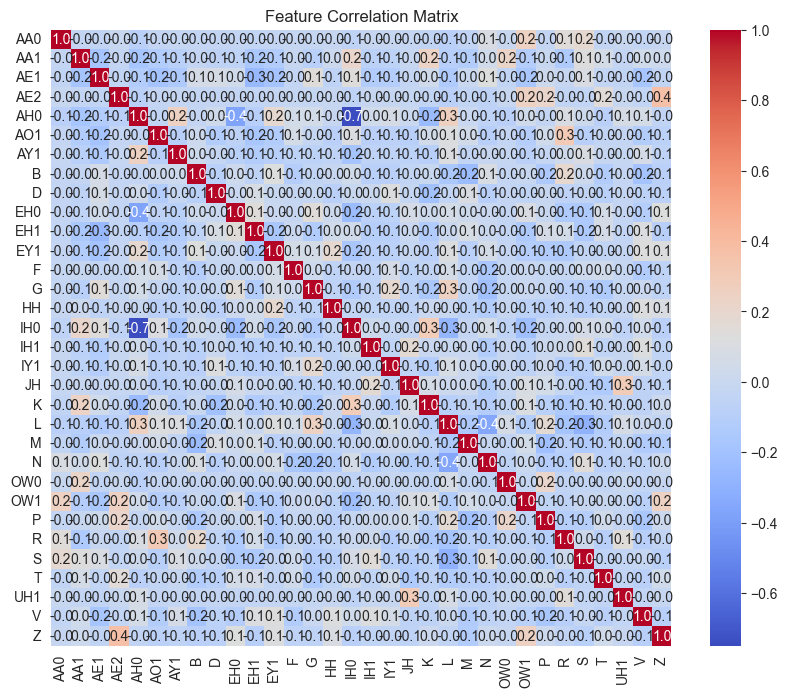

,Feature,VIF
0,AA0,1.797883
1,AA1,12.151341
2,AE1,24.295500
3,AE2,2.123477
4,AH0,63.877386
5,AO1,12.804207
6,AY1,7.487775
7,B,2.551980
8,D,2.002115
9,EH0,13.851950


In [30]:
# Check the multicolinearity and reduce the feature dimensions
check_multicollinearity(np.array(list(phoneme_one_hot_dict.values())),all_phonemes)
# Print the words tha contain AE0, W, ER0, and Y
for syllable, value in syllables.items():
    if value and "AE0" in value:
        print(f"{syllable}: {value} contains AE0")
    if value and "W" in value:
        print(f"{syllable}: {value} contains W")
    if value and "ER0" in value:
        print(f"{syllable}: {value} contains ER0")
    if value and "Y" in value:
        print(f"{syllable}: {value} contains Y")
    if value and "UW1" in value:
        print(f"{syllable}: {value} contains UW1")
    if value and "HH" in value and "M" in value:
        print(f"{syllable}: {value} contains both HH and M")
    if value and "T" in value and "L" in value and "AH0" in value:
        print(f"{syllable}: {value} contains T, L and AH0")
    if value and "OW1" in value and "M" in value and "N" in value:
        print(f"{syllable}: {value} contains OW1, M and N")
# I think it is safe to reduce ER0, Y, UW1, AE0, and W
# Then: humor - HH and M, tulip - 'T', 'L', 'AH0', 'P', women - 'OW1', 'M', 'N'

# reduce the dimensions:
indices_to_remove=[all_phonemes.index("ER0"),all_phonemes.index("Y"),all_phonemes.index("UW1"),all_phonemes.index("AE0"),all_phonemes.index("W")]
phoneme_one_hot_dict_filt = {key: vec for key, vec in phoneme_one_hot_dict.items()}
for i, (key, vec) in enumerate(phoneme_one_hot_dict.items()):
    # Create a copy of the vector with specified indices removed
    filtered_vec = np.delete(vec, indices_to_remove)
    phoneme_one_hot_dict_filt[key] = filtered_vec
all_phonemes_filt = []
all_phonemes_filt = [p for i, p in enumerate(all_phonemes) if i not in indices_to_remove]

# Check the multicolinearity again
check_multicollinearity(np.array(list(phoneme_one_hot_dict_filt.values())),all_phonemes_filt)


--- Running PCA with automatic component selection (95% variance) ---
--- Starting PCA Analysis ---

Original data shape: (168, 32) (samples x features)

Explained variance per principal component:
 [0.07911221 0.0614599  0.05808549 0.05305683 0.05158706 0.04855519
 0.04796426 0.04612562 0.04259553 0.03865115 0.03723509 0.03546454
 0.03476687 0.03343842 0.03129818 0.03073112 0.02928017 0.02735709
 0.02653309 0.02450021 0.0240585  0.02215305 0.02055625 0.019104
 0.01745174 0.01676574 0.01563021 0.01339423 0.01056599 0.00166259
 0.00063231 0.00022741]

Cumulative explained variance:
 [0.07911221 0.14057211 0.1986576  0.25171443 0.30330149 0.35185668
 0.39982094 0.44594656 0.48854209 0.52719324 0.56442832 0.59989286
 0.63465972 0.66809814 0.69939632 0.73012743 0.7594076  0.78676469
 0.81329778 0.83779799 0.86185649 0.88400954 0.90456579 0.92366979
 0.94112153 0.95788727 0.97351747 0.98691171 0.9974777  0.99914028
 0.99977259 1.        ]

To retain at least 90% of the variance, it's sugge

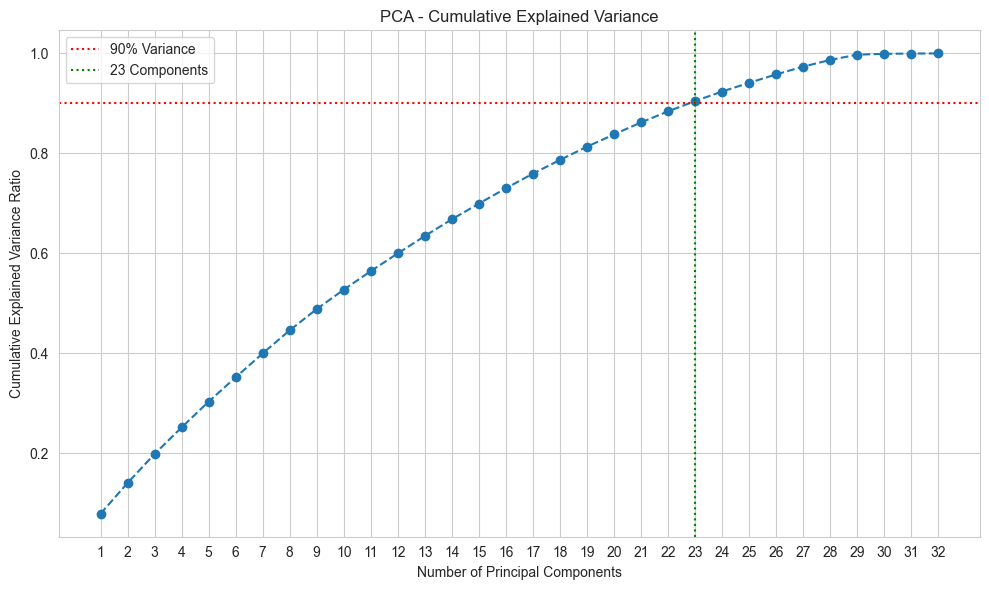


--- Visualizing Feature Loadings ---


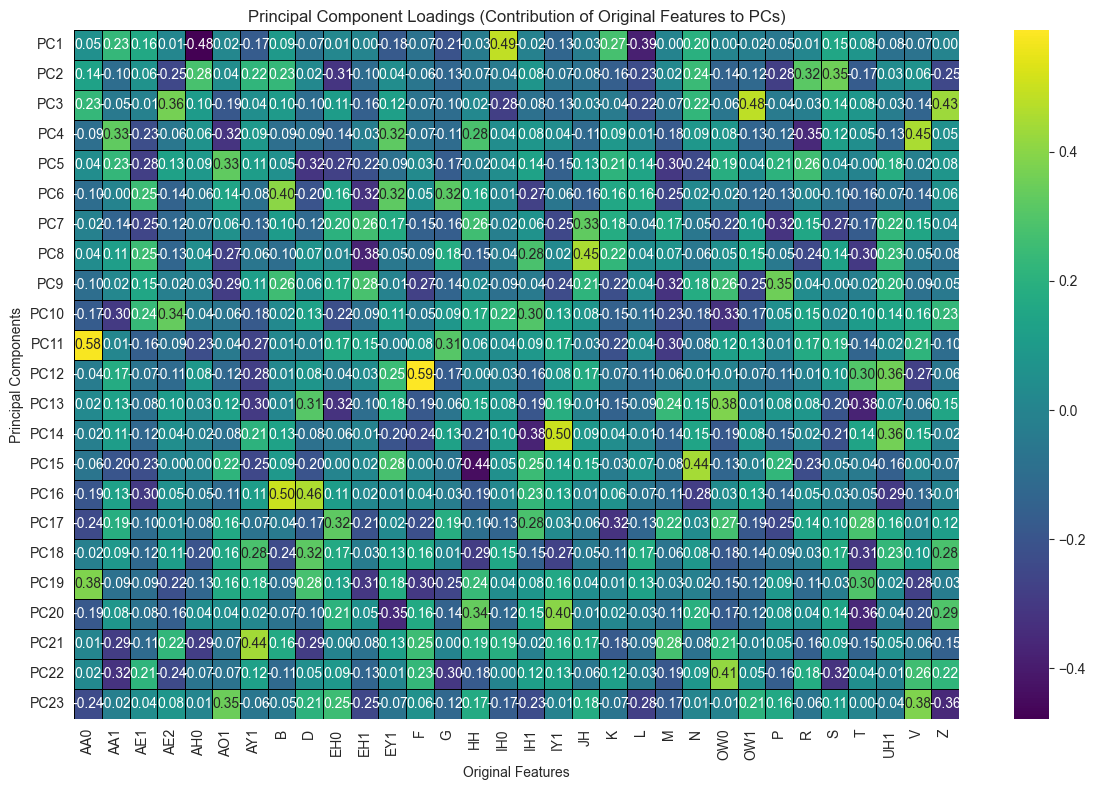

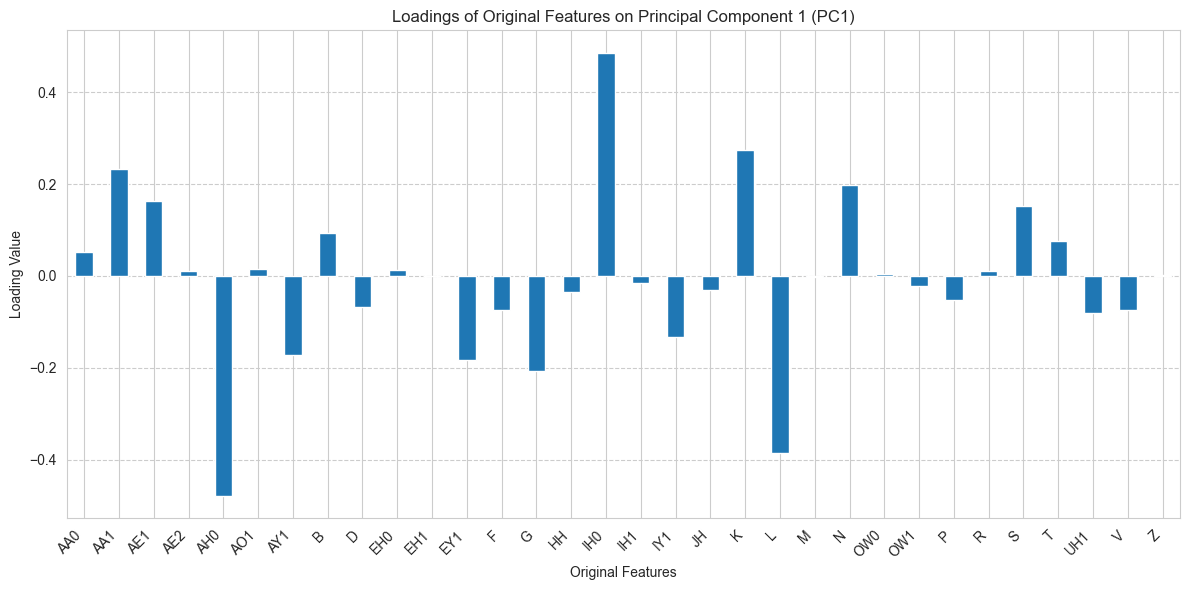


--- Visualizing Clustered Feature Correlations ---


<Figure size 1000x800 with 0 Axes>

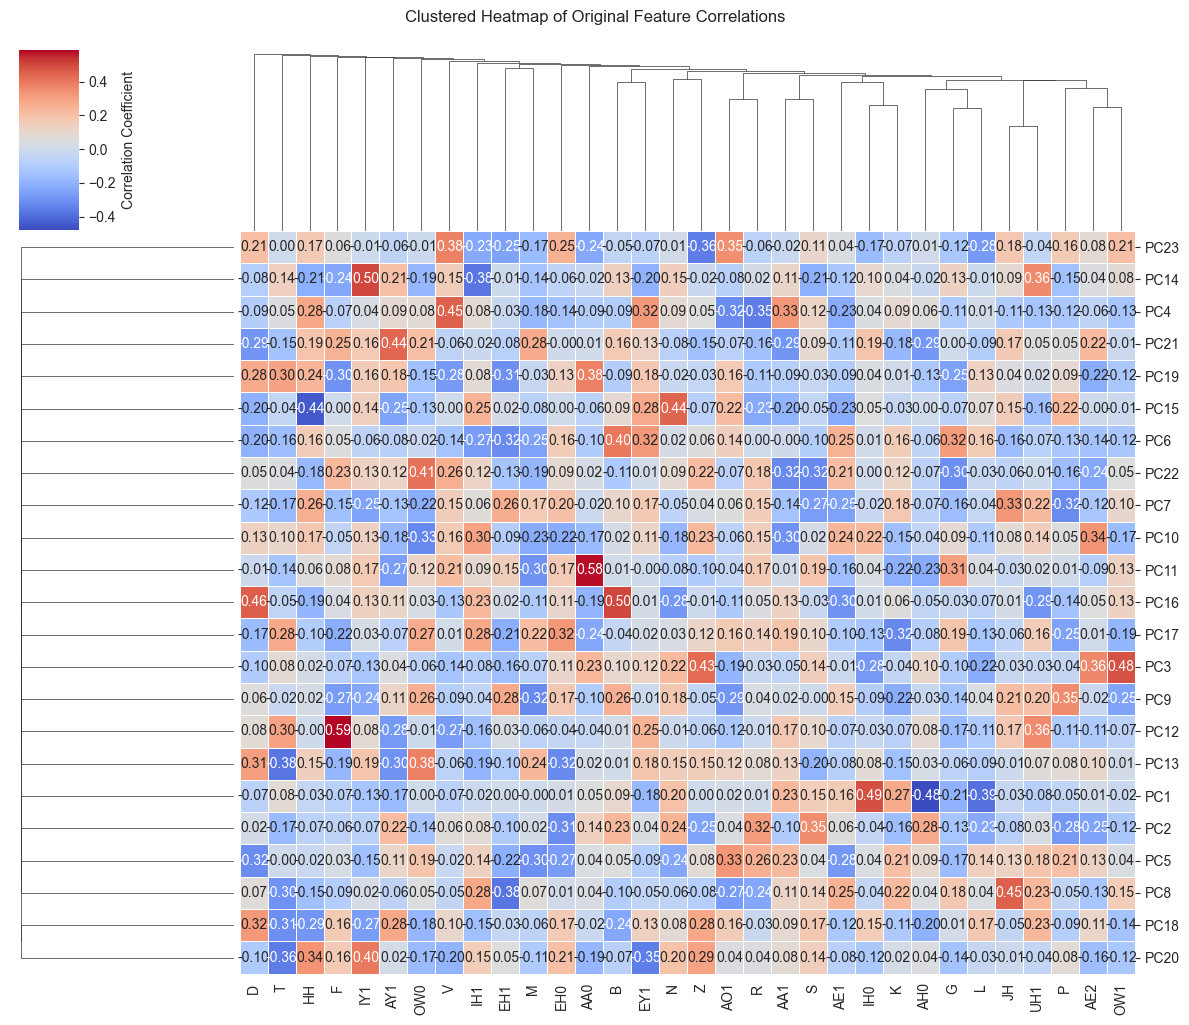


--- PCA Analysis Complete ---
bacon : [0.4774098389304881, 0.776658639036478, 0.3139921397735393, 0.6186918446831345, 0.43105603946334003, 0.8131297683863701, 0.6107933131961453, 0.3784619021716288, 0.44306978012083764, 0.46011948274254916, 0.1104042653942873, 0.37818444601070084, 0.3888649068524214, 0.3616977561557248, 0.9103446336364052, 0.6947944492367254, 0.35501987616048347, 0.2775823773274331, 0.37307309302051106, 0.3117656990569918, 0.5389792588149968, 0.36988623284526156, 0.455864020810059]
bagel : [0.08132346330838724, 0.6617817655966333, 0.20130754362381167, 0.5019105546218869, 0.3776781777172804, 1.0, 0.4927611918175271, 0.43484198485746833, 0.3978118671370952, 0.5407318677580724, 0.28816932761408504, 0.2782808170006601, 0.3379819023803671, 0.37787076262269403, 0.7193635225126627, 0.7204716841224182, 0.5452093668849242, 0.38104382102574275, 0.2601613062797765, 0.09848047799842957, 0.6203447805382638, 0.07839479465137034, 0.2556469911151556]
banel : [0.4123329144776198, 0.76

In [35]:
# PCA
print("\n--- Running PCA with automatic component selection (95% variance) ---")
pca_results_auto, _, _ = perform_pca_on_acoustic_features(
    phoneme_one_hot_dict_filt,original_feature_names=all_phonemes_filt,
    n_components=None, # Let the function decide
    min_variance_retention=0.9
)
phoneme_one_hot_dict_filt_pca = pca_results_auto.to_dict('index')
phoneme_one_hot_dict_filt_pca = {key: list(value.values()) for key, value in phoneme_one_hot_dict_filt_pca.items()}

for key, values in list(phoneme_one_hot_dict_filt_pca.items())[:5]:  # Show first 5 entries
    print(key, ":", values)


In [62]:
# save the phoneme_one_hot_dicphoneme_one_hot_dictt
import pickle
phoneme_one_hot_dict_path = "phoneme_one_hot_dict.pickle"
with open(phoneme_one_hot_dict_path, 'wb') as handle:
    pickle.dump(phoneme_one_hot_dict_filt, handle)

In [63]:
# # Read the saved one hot dict. Just for demonstration
# import pandas as pd
# d= pd.read_pickle("phoneme_one_hot_dict.pickle")

## 2. Acoustic feature (Power envelope at five frequency bins)
### 2.1. Read normolized binned envelope 
(The matrix was generated by `get_stims_envelope.m`)

In [38]:
envelope_feature_dict = {}

with open("envelope_power_bins.txt", "r") as file:
    for line in file:
        parts = line.strip().split("\t")
        key = parts[0]
        values = list(map(float, parts[1:]))  # Convert remaining columns to float
        envelope_feature_dict[key] = values
feature_names=['50.00 Hz','120.58 Hz','209.04 Hz','319.88 Hz','458.78 Hz','632.84 Hz','850.96 Hz','1124.30 Hz','1466.84 Hz','1896.08 Hz','2433.98 Hz','3108.04 Hz','3952.74 Hz','5011.26 Hz','6337.74 Hz','8000.00 Hz']
# Print a sample of the dictionary
for key, values in list(envelope_feature_dict.items())[:5]:  # Show first 5 entries
    print(key, ":", values)

bacon : [0.296571, 0.679119, 0.654061, 0.912844, 0.623807, 0.648764, 0.137363, 0.029119, 0.015504, 0.062601, 0.641239, 0.716769, 0.487837, 0.308751, 0.148496, 0.014086]
bagel : [0.294559, 0.562094, 0.63364, 0.886278, 0.650092, 0.561301, 0.208617, 0.234761, 0.049883, 0.016795, 0.518351, 0.811275, 0.528009, 0.38513, 0.077717, 0.011942]
banel : [0.433478, 0.696933, 0.69218, 0.575856, 0.439453, 0.899617, 0.678323, 0.355078, 0.158576, 0.440505, 0.735245, 0.818001, 0.541304, 0.442179, 0.399292, 0.02589]
banic : [0.310589, 0.598114, 0.659623, 0.499222, 0.495335, 0.974619, 0.717401, 0.193477, 0.061496, 0.275164, 0.806595, 0.721089, 0.349668, 0.467902, 0.37589, 0.013435]
baron : [0.278518, 0.606174, 0.331545, 0.685306, 0.199569, 0.58373, 0.785836, 0.319984, 0.170117, 0.612108, 0.666829, 0.430677, 0.419611, 0.313882, 0.212093, 0.010565]


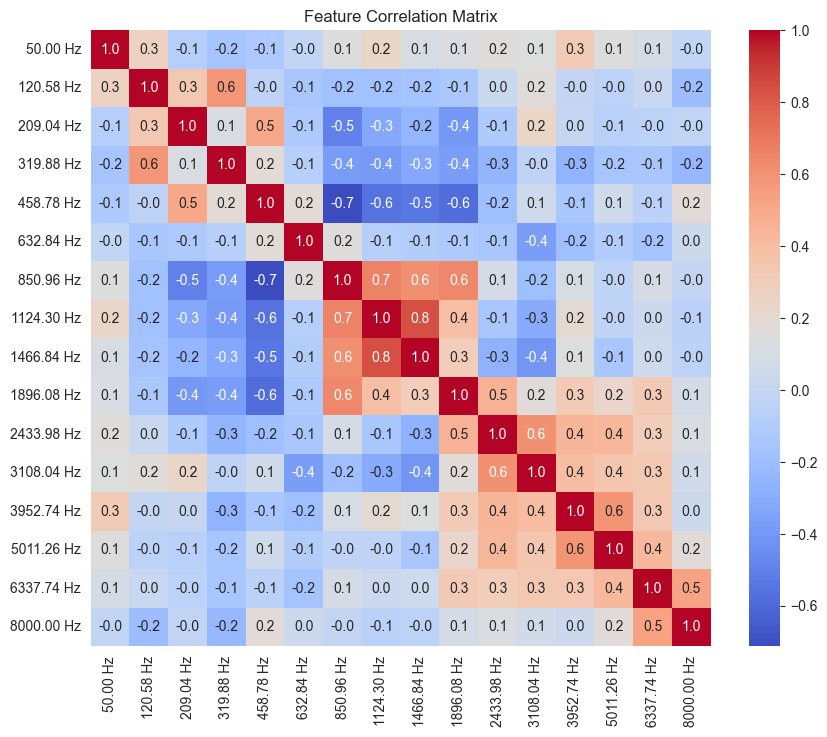

,Feature,VIF
0,50.00 Hz,2.764945
1,120.58 Hz,41.019661
2,209.04 Hz,30.227933
3,319.88 Hz,34.290703
4,458.78 Hz,24.242304
5,632.84 Hz,20.798270
6,850.96 Hz,25.037287
7,1124.30 Hz,16.435708
8,1466.84 Hz,14.184847
9,1896.08 Hz,10.626047


In [39]:
# # Check the multicolinearity and reduce the feature dimensions
check_multicollinearity(np.array(list(envelope_feature_dict.values())),
                        feature_names)


--- Running PCA with automatic component selection (95% variance) ---
--- Starting PCA Analysis ---

Original data shape: (168, 16) (samples x features)

Explained variance per principal component:
 [0.25949027 0.19794997 0.11170723 0.07988084 0.07071881 0.0675403
 0.05163754 0.04146729 0.02270823 0.0225378  0.01846967 0.01702189
 0.01421956 0.00925895 0.00807515 0.00731649]

Cumulative explained variance:
 [0.25949027 0.45744024 0.56914747 0.64902831 0.71974711 0.78728742
 0.83892496 0.88039225 0.90310048 0.92563828 0.94410795 0.96112984
 0.9753494  0.98460835 0.99268351 1.        ]

To retain at least 90% of the variance, it's suggested to select 9 principal components.

Final PCA transformed data shape: (168, 9)
PCA transformed data (first 5 rows):
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
bacon -3.003674  0.966783  1.201190 -0.886033  0.720371  0.232149 -0.147026   
bagel -2.514366  0.851479  1.024409 -0.422828  0.968745 -0.501224  0.247851   

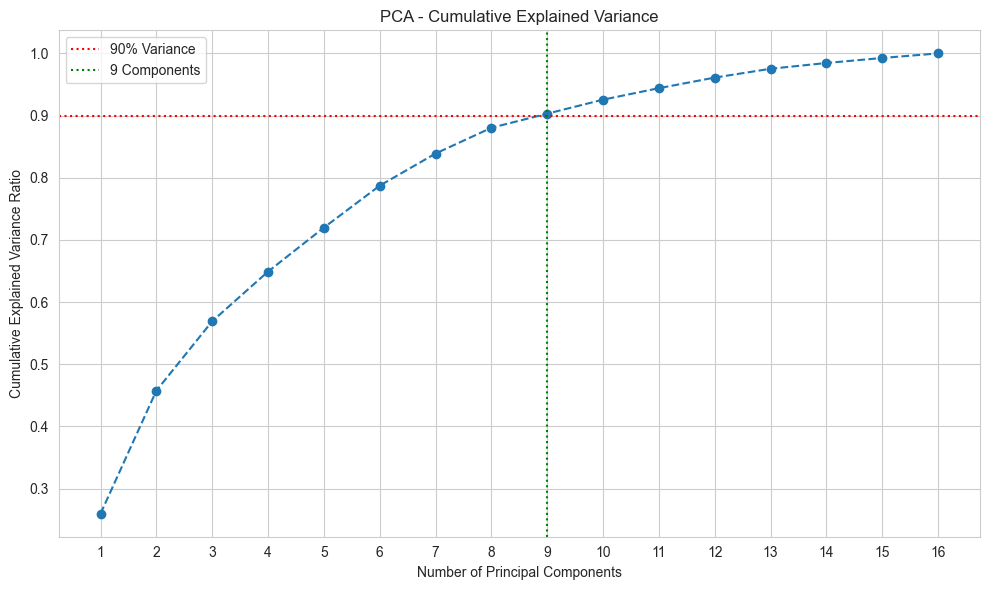


--- Visualizing Feature Loadings ---


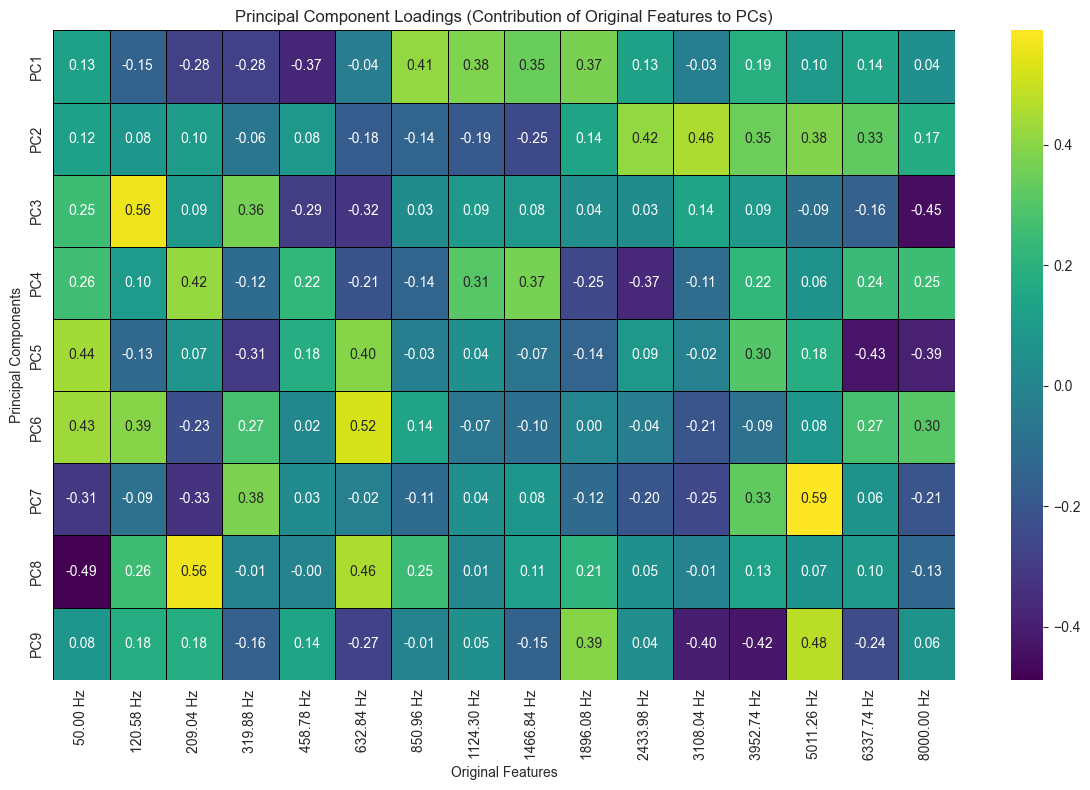

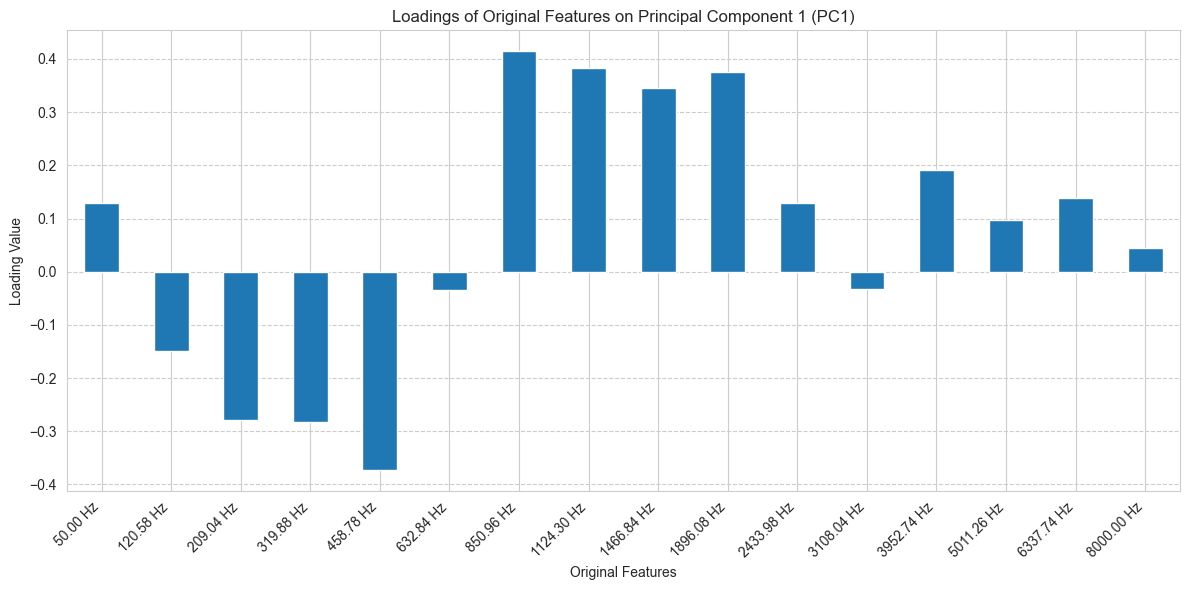


--- Visualizing Clustered Feature Correlations ---


<Figure size 1000x800 with 0 Axes>

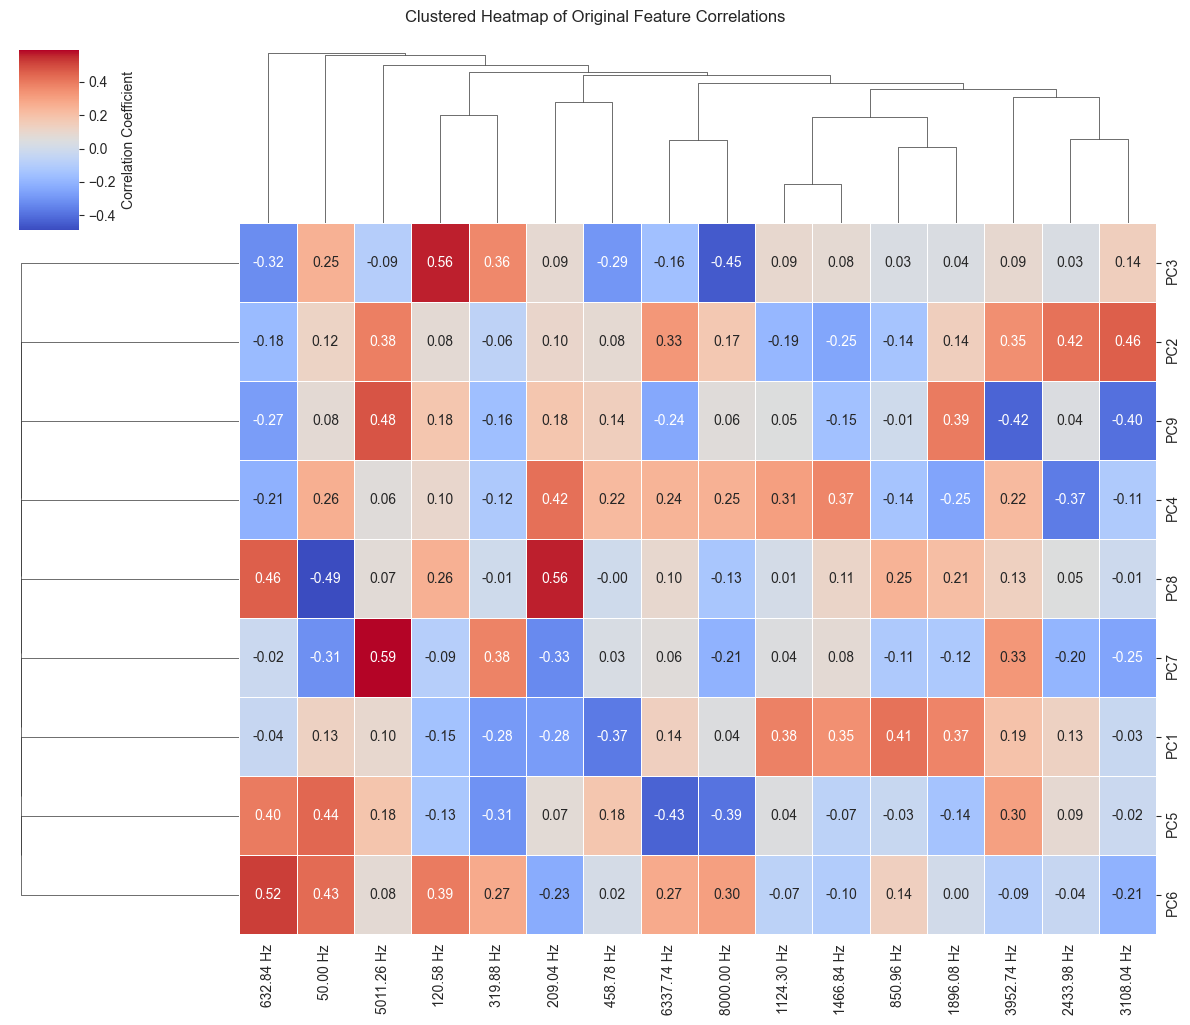


--- PCA Analysis Complete ---
bacon : [0.16566700421210406, 0.660303480011847, 0.7433815364783871, 0.3745083996013706, 0.6121153464234638, 0.47575075552793955, 0.32811675492498016, 0.29941455187664123, 0.12361629980883007]
bagel : [0.21793007661869535, 0.6475876791765206, 0.7187979452993982, 0.44400809103573385, 0.6541455970830069, 0.3464866704694182, 0.3819726507503842, 0.20026966495704462, 0.11381268757324678]
banel : [0.5141545842299822, 0.7330601414312581, 0.6691270019680748, 0.4027254879547371, 0.73805150300891, 0.6312846553000403, 0.18929861052184685, 0.6791230500655667, 0.1762519390935206]
banic : [0.44667896476573243, 0.6766244341668566, 0.5126983114534143, 0.27923092083733747, 0.740005910338442, 0.6086412480463913, 0.17745751785451813, 0.6751239177593912, 0.27291048239407056]
baron : [0.6092465091930799, 0.5209027825474887, 0.7199642258763709, 0.18822285178331966, 0.4809948573629806, 0.5135955278094264, 0.31177014165937034, 0.284224984357581, 0.40033174917571007]


In [40]:
# PCA
print("\n--- Running PCA with automatic component selection (95% variance) ---")
pca_results_auto, _, _ = perform_pca_on_acoustic_features(
    envelope_feature_dict,original_feature_names=feature_names,
    n_components=None, # Let the function decide
    min_variance_retention=0.9
)
envelope_feature_dict_pca = pca_results_auto.to_dict('index')
envelope_feature_dict_pca = {key: list(value.values()) for key, value in envelope_feature_dict_pca.items()}

for key, values in list(envelope_feature_dict_pca.items())[:5]:  # Show first 5 entries
    print(key, ":", values)

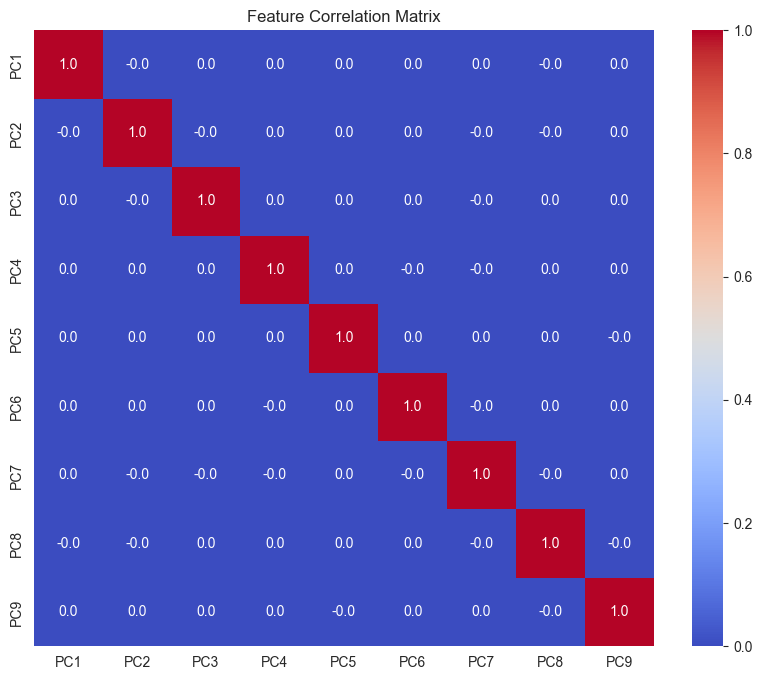

,Feature,VIF
0,PC1,5.540127
1,PC2,7.872522
2,PC3,9.056710
3,PC4,8.592837
4,PC5,7.465468
5,PC6,6.062794
6,PC7,7.819568
7,PC8,7.474145
8,PC9,5.333770


In [41]:
check_multicollinearity(np.array(list(envelope_feature_dict_pca.values())),
                        ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])

In [42]:
# Save dictionary
import pickle
envelope_feature_dict_path = "envelope_feature_dict.pickle"
with open(envelope_feature_dict_path, 'wb') as handle:
    pickle.dump(envelope_feature_dict_pca, handle)